In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from calendar import c
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/焦煤港口库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['焦煤港口库存'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet

In [5]:
'''
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值_全量']],
    on='Date',
    how='left'
)
sheet_daily['中国10年期国债收益率Non-Trend/F0.2'] = sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].fillna(sheet_daily['预测值_全量'])
sheet_daily = sheet_daily.drop(columns=['预测值_全量'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
'''

"\n# 合并 sheet1 和 sheet2 的数据到 sheet\nsheet_daily = sheet.copy()\nsheet_daily.index.name = 'Date'\nsheet_daily = sheet_daily.reset_index()\n\n# 合并 sheet1 的美国10年通胀预期数据\nsheet_daily = pd.merge(\n    sheet_daily,\n    sheet1[['Date', '预测值_全量']],\n    on='Date',\n    how='left'\n)\nsheet_daily['中国10年期国债收益率Non-Trend/F0.2'] = sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].fillna(sheet_daily['预测值_全量'])\nsheet_daily = sheet_daily.drop(columns=['预测值_全量'])\n\n# 将 sheet_daily 重新赋值给 sheet\nsheet = sheet_daily.copy()\nsheet = sheet.set_index('Date')\n"

In [6]:
sheet.columns

Index(['焦煤港口库存', '澳煤和蒙煤仓单价基差', '日均粗钢产量/12MMA同比', '焦煤基差率/10DMA', '澳煤和临汾主焦煤价差',
       '螺纹高炉利润/上海/即期', '全球发往中国焦煤/20DMA', '全球海运焦煤出口中国总量/周度/4WMA'],
      dtype='object')

In [7]:
sheet.tail()

,焦煤港口库存,澳煤和蒙煤仓单价基差,日均粗钢产量/12MMA同比,焦煤基差率/10DMA,澳煤和临汾主焦煤价差,螺纹高炉利润/上海/即期,全球发往中国焦煤/20DMA,全球海运焦煤出口中国总量/周度/4WMA
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
################################# 处理缺失值 #################################
fill_methods = { 
'澳煤和蒙煤仓单价基差':'interpolate',
'日均粗钢产量/12MMA同比':'interpolate', 
'焦煤基差率/10DMA':'interpolate', 
'澳煤和临汾主焦煤价差':'interpolate',
'螺纹高炉利润/上海/即期':'interpolate',
'全球发往中国焦煤/20DMA':'interpolate',
'全球海运焦煤出口中国总量/周度/4WMA':'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '焦煤港口库存'] = sheet.loc[:last_day, '焦煤港口库存'].interpolate(method='linear')   

#################################  因子处理  #################################
# 将日度数据转换为周度数据
# 首先创建临时DataFrame用于周度转换
temp_df = sheet.copy()
temp_df.index = pd.to_datetime(temp_df.index)

 # 使用7天滚动窗口平滑数据
sheet['澳煤和蒙煤仓单价基差'] = temp_df['澳煤和蒙煤仓单价基差'].rolling(window=7, min_periods=1).mean()
sheet['焦煤基差率/10DMA'] = temp_df['焦煤基差率/10DMA'].rolling(window=14, min_periods=1).mean()   
sheet['澳煤和临汾主焦煤价差'] = temp_df['澳煤和临汾主焦煤价差'].rolling(window=14, min_periods=1).mean()  
sheet['螺纹高炉利润/上海/即期'] = temp_df['螺纹高炉利润/上海/即期'].rolling(window=14, min_periods=1).mean()  
sheet['全球发往中国焦煤/20DMA'] = temp_df['全球发往中国焦煤/20DMA'].rolling(window=14, min_periods=1).mean()  

sheet['澳煤和蒙煤仓单价基差_提前80天'] = sheet['澳煤和蒙煤仓单价基差'].shift(80)   
sheet['日均粗钢产量/12MMA同比_提前120天'] = sheet['日均粗钢产量/12MMA同比'].shift(120)
sheet['焦煤基差率/10DMA_提前20天'] = sheet['焦煤基差率/10DMA'].shift(20)   
sheet['澳煤和临汾主焦煤价差_提前70天'] = sheet['澳煤和临汾主焦煤价差'].shift(70)
sheet['螺纹高炉利润/上海/即期_提前110天'] = sheet['螺纹高炉利润/上海/即期'].shift(110)
sheet['全球发往中国焦煤/20DMA_提前40天'] = sheet['全球发往中国焦煤/20DMA'].shift(40)
sheet['全球海运焦煤出口中国总量/周度/4WMA_提前42天'] = sheet['全球海运焦煤出口中国总量/周度/4WMA'].shift(42)


sheet['澳煤和蒙煤仓单价基差_提前80天_逆序'] = reverse_column(sheet, '澳煤和蒙煤仓单价基差_提前80天')  
sheet['澳煤和临汾主焦煤价差_提前70天_逆序'] = reverse_column(sheet, '澳煤和临汾主焦煤价差_提前70天')
sheet['螺纹高炉利润/上海/即期_提前110天_逆序'] = reverse_column(sheet, '螺纹高炉利润/上海/即期_提前110天')





################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2021-04-17')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['焦煤港口库存'].notna())
]

################################# 数据 读取-处理 结束 #################################

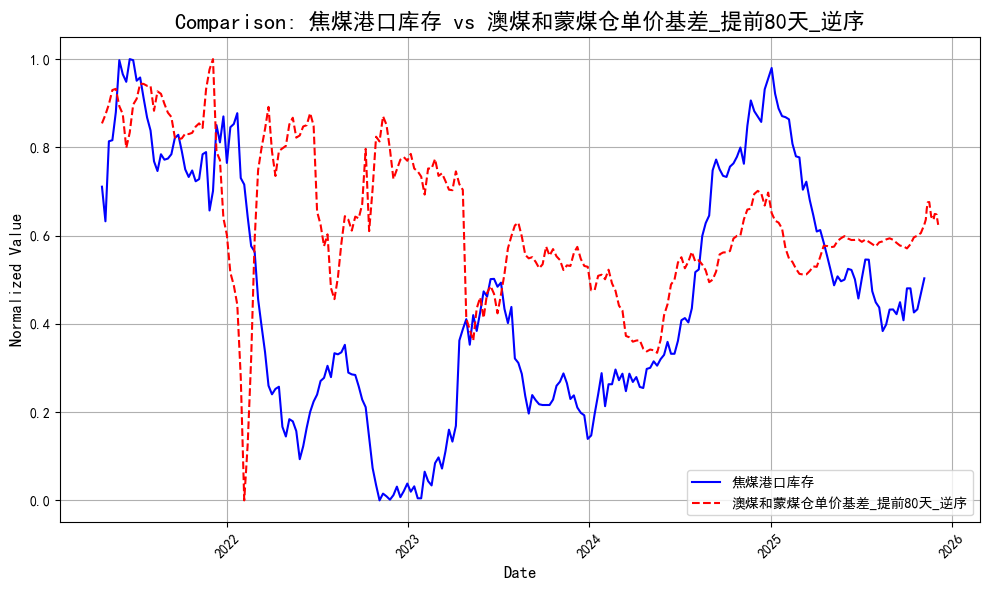

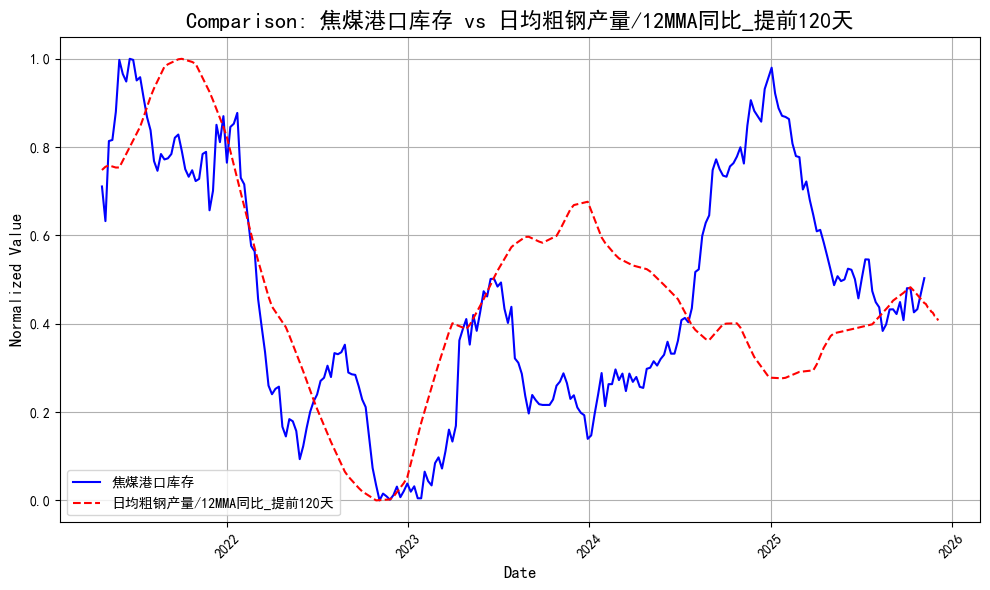

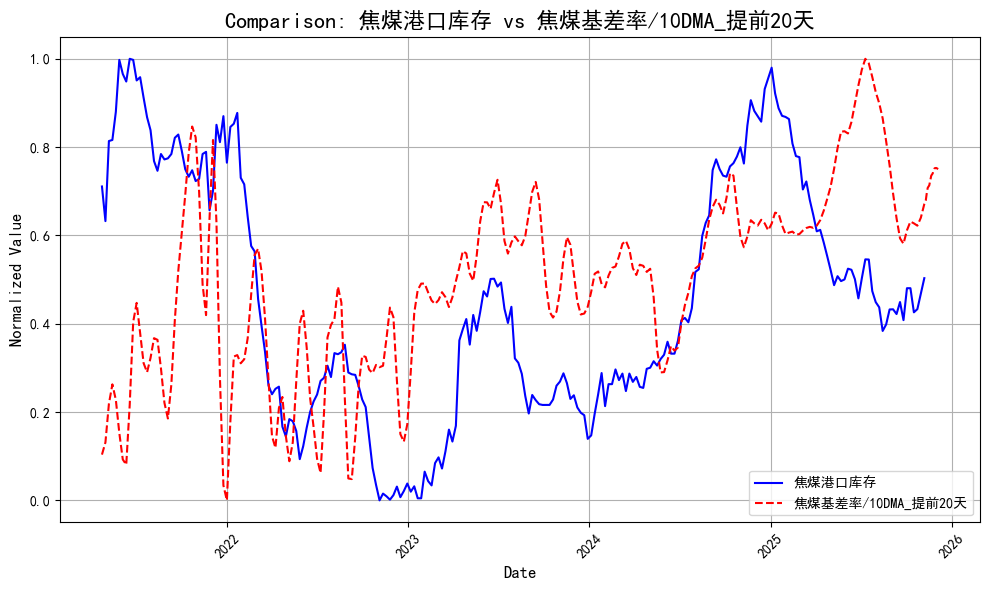

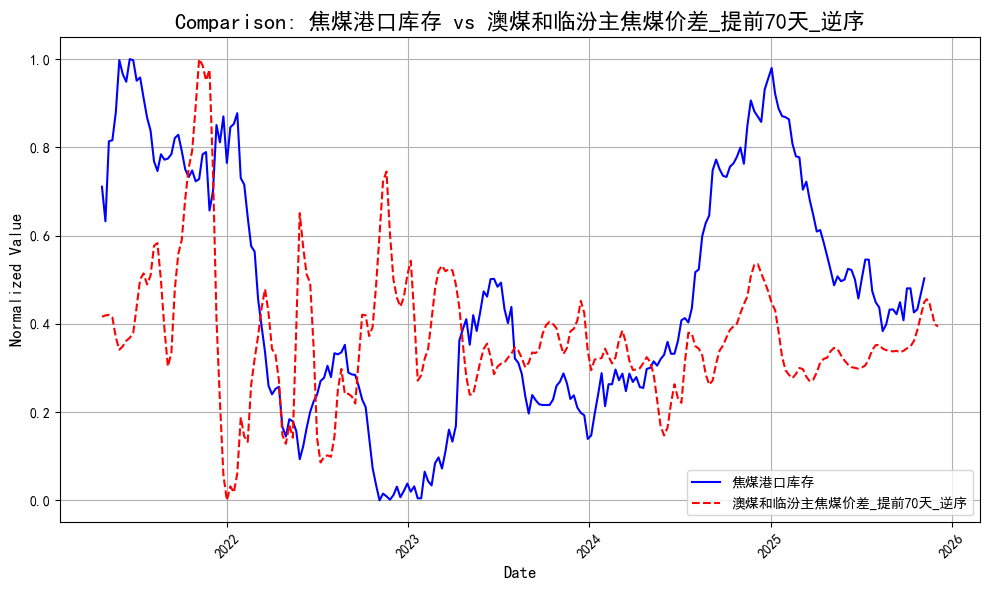

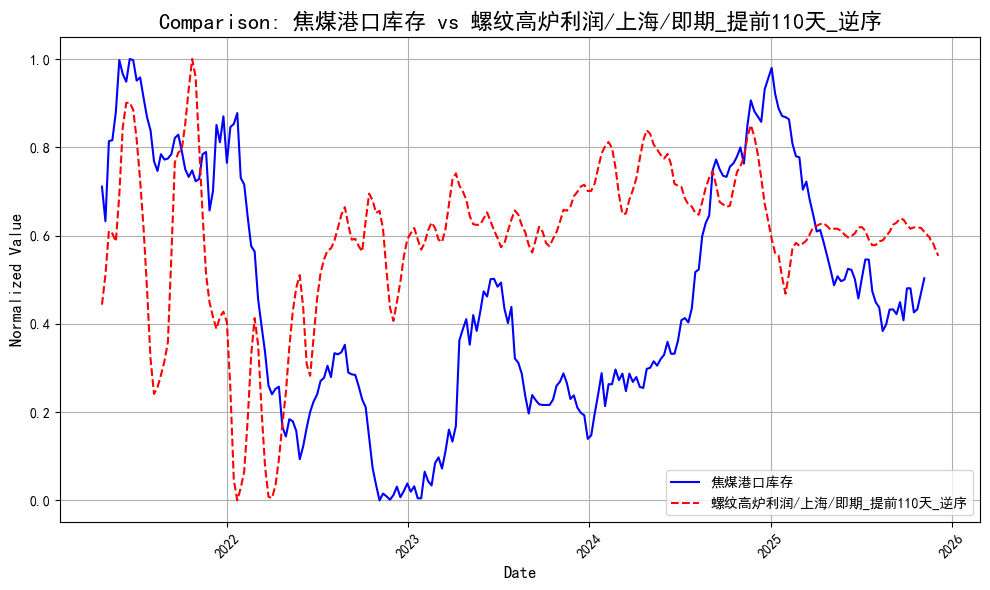

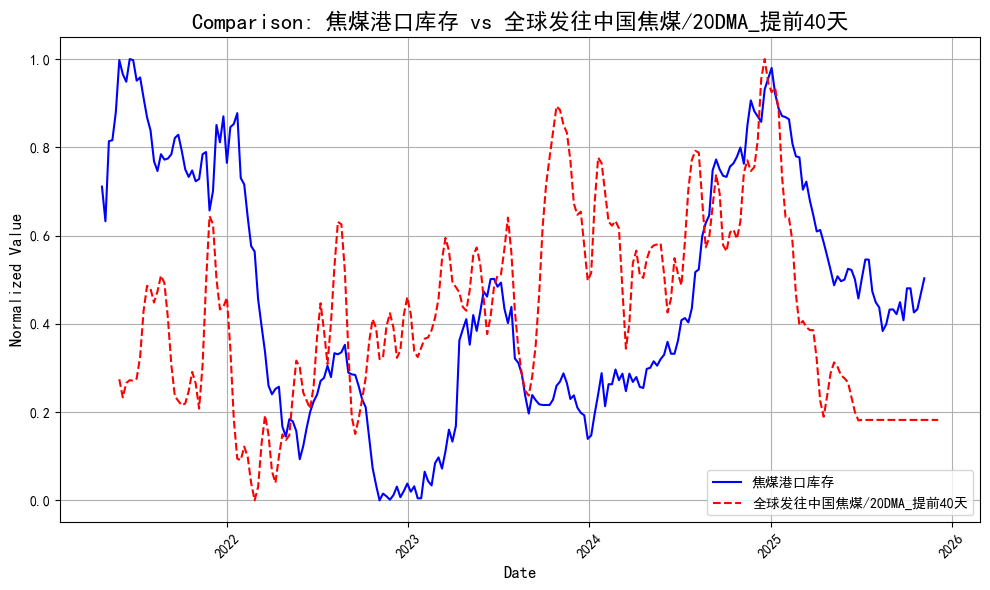

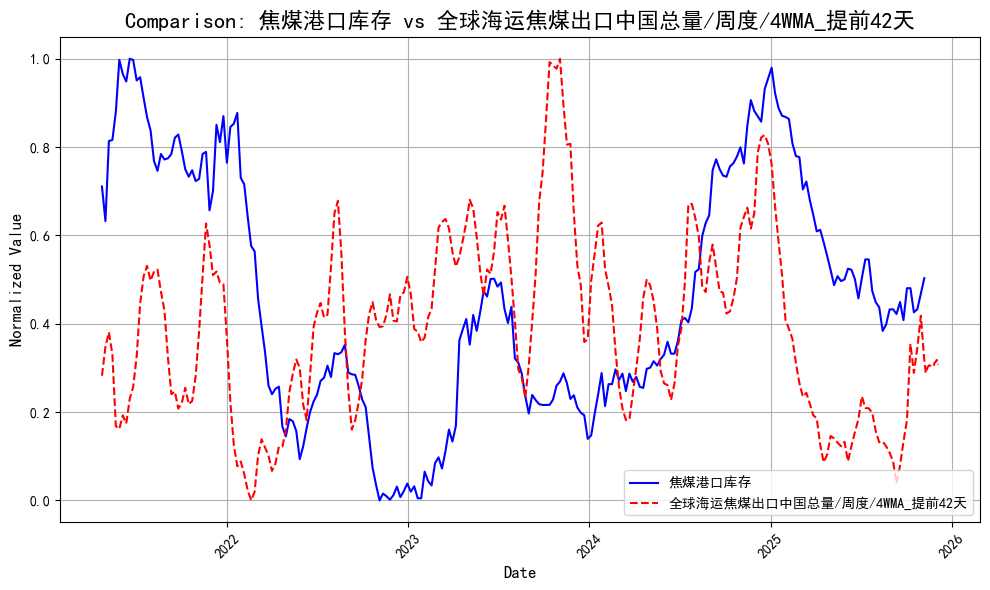

In [9]:
sheet_daily_plot = sheet_daily.set_index('Date')
sheet_daily_plot = sheet_daily_plot['2020':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='焦煤港口库存', 
    compare_cols=[
        '澳煤和蒙煤仓单价基差_提前80天_逆序',
        '日均粗钢产量/12MMA同比_提前120天',
        '焦煤基差率/10DMA_提前20天',
        '澳煤和临汾主焦煤价差_提前70天_逆序',
        '螺纹高炉利润/上海/即期_提前110天_逆序',
        '全球发往中国焦煤/20DMA_提前40天',
        '全球海运焦煤出口中国总量/周度/4WMA_提前42天'
        ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
#        '中国10年期国债收益率Non-Trend/F0.2',
        '澳煤和蒙煤仓单价基差_提前80天_逆序',
        '日均粗钢产量/12MMA同比_提前120天',
        '焦煤基差率/10DMA_提前20天',
        '澳煤和临汾主焦煤价差_提前70天_逆序',
        '螺纹高炉利润/上海/即期_提前110天_逆序',
#        '全球发往中国焦煤/20DMA_提前40天',
        '全球海运焦煤出口中国总量/周度/4WMA_提前42天'
]

predict_column = '焦煤港口库存'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.09,  # 较小的学习率
    'max_depth':10,  # 控制树的深度防止过拟合
    'min_child_weight': 0.8,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.7,  # 特征随机采样
    'gamma': 0.2755,  # 控制分裂
    'reg_alpha': 0.9,  # L1正则化
    'reg_lambda': 0.8,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 1,
#    'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=50,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:21.80782	train-rmse:108.11774


[500]	eval-rmse:19.82866	train-rmse:0.41149


[1000]	eval-rmse:19.82459	train-rmse:0.39216


[1500]	eval-rmse:19.82284	train-rmse:0.38486


[2000]	eval-rmse:19.83808	train-rmse:0.37837


[2438]	eval-rmse:19.82999	train-rmse:0.37393


训练集 MSE (DMatrix): 0.142, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 393.2269, 测试集 R² (DMatrix): -0.2703


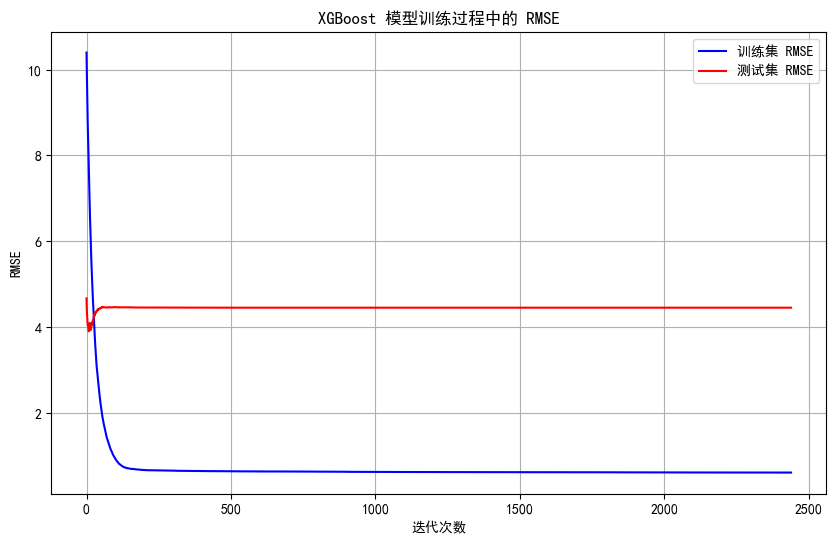

In [11]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:103.67575


[500]	train-rmse:0.40874


[1000]	train-rmse:0.39094


[1500]	train-rmse:0.38098


[2000]	train-rmse:0.37423


[2500]	train-rmse:0.37004


[3000]	train-rmse:0.36770


[3500]	train-rmse:0.36464


[4000]	train-rmse:0.36194


[4500]	train-rmse:0.35919


[4999]	train-rmse:0.35688


全部数据 MSE: 0.1292, 全部数据 R²: 1.0


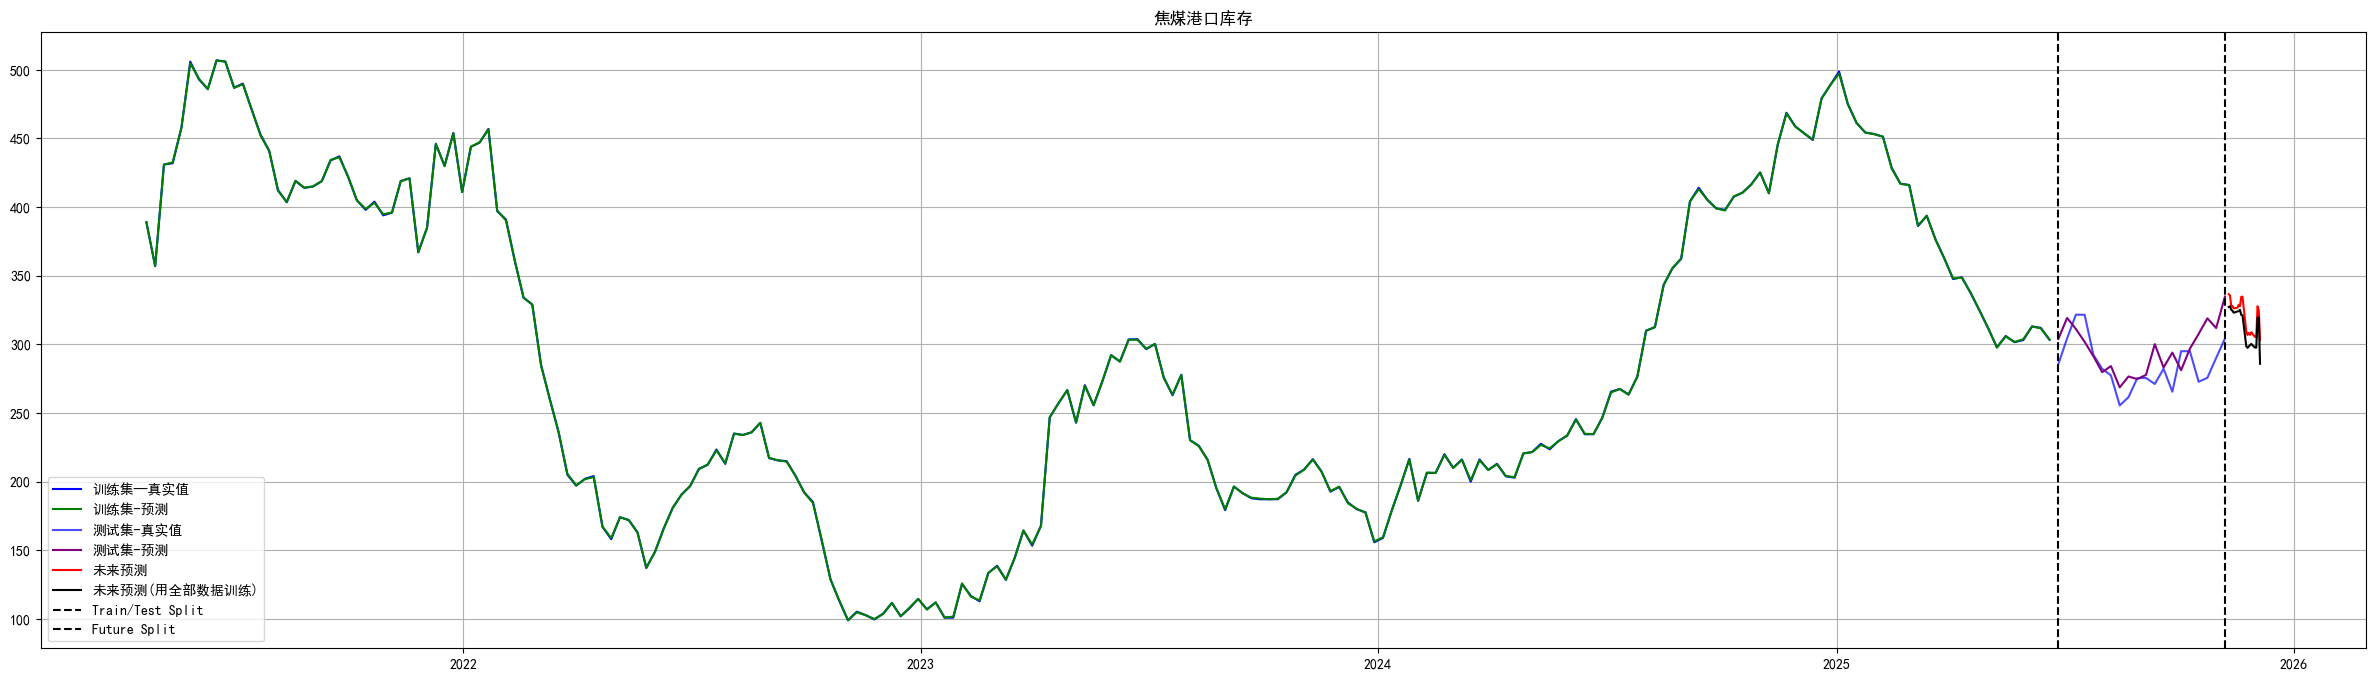

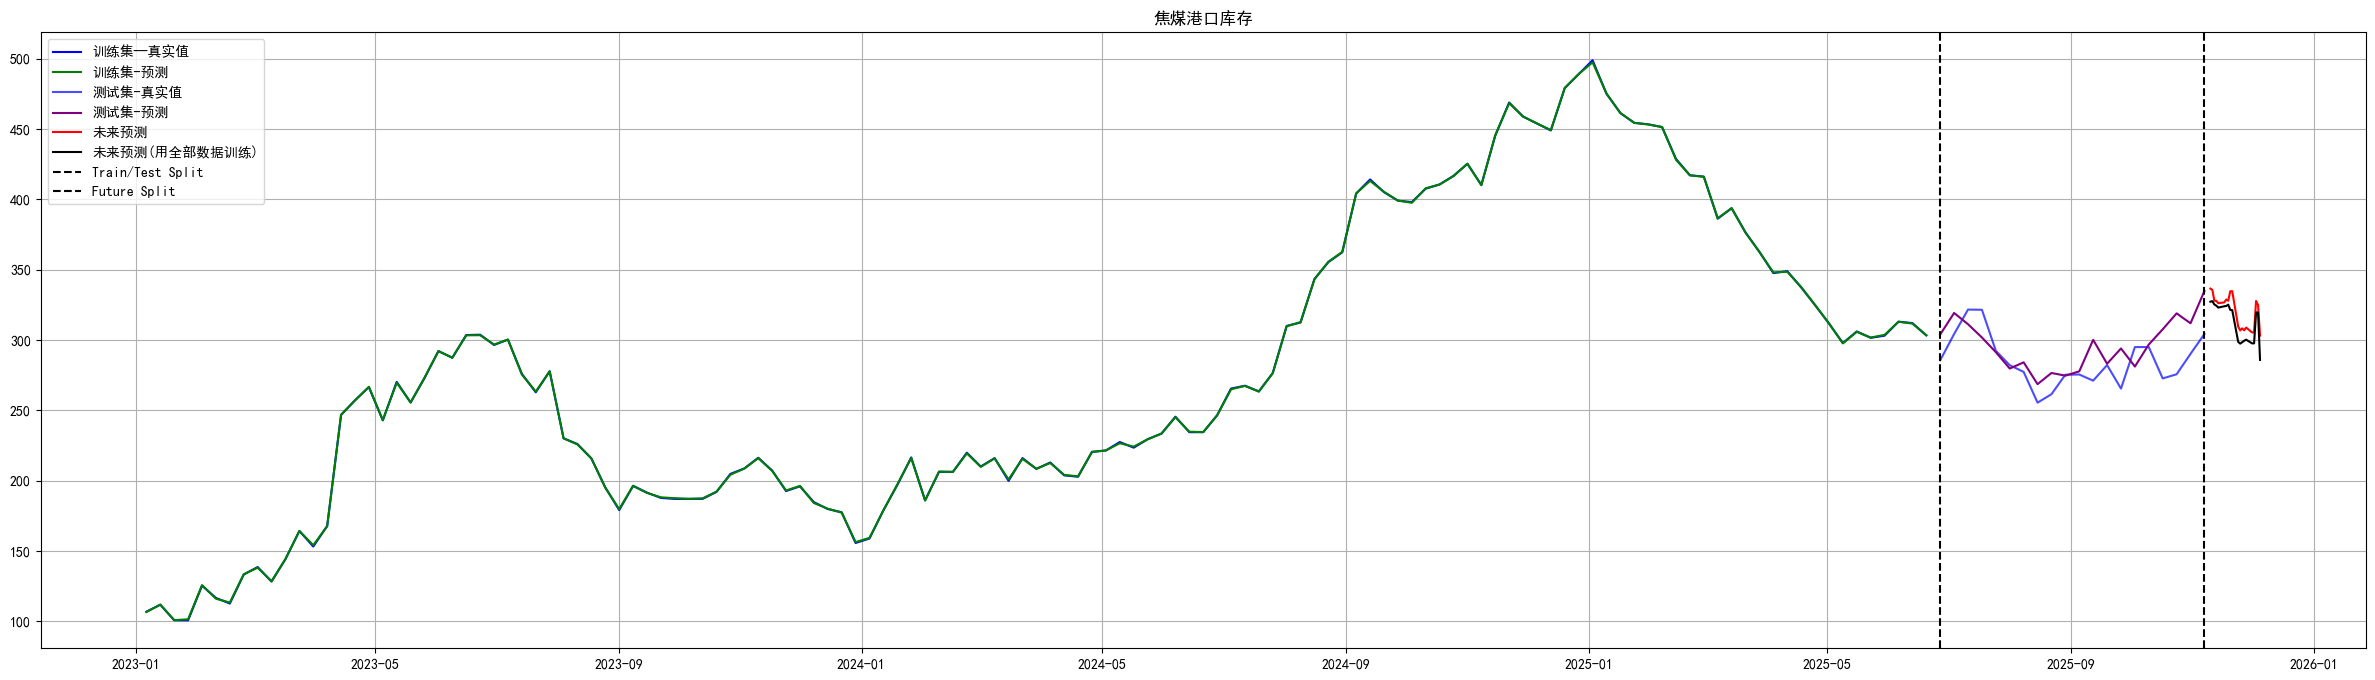

In [13]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('焦煤港口库存')
plt.legend()
plt.grid(True)
plt.show()
# 筛选2021年及以后的数据
start_date = pd.to_datetime('2023-01-01')
train_data_filtered = train_data[train_data['Date'] >= start_date]
y_train_filtered = y_train[train_data['Date'] >= start_date]
y_train_pred_filtered = y_train_pred_dmatrix[train_data['Date'] >= start_date]

# 重新绘制图表，只显示2021年及以后的数据
plt.figure(figsize=(30, 8))
plt.plot(train_data_filtered['Date'], y_train_filtered, label='训练集—真实值', color='blue')
plt.plot(train_data_filtered['Date'], y_train_pred_filtered, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('焦煤港口库存')
plt.legend()
plt.grid(True)
plt.show()

---

In [14]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/焦煤港口库存_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
168,2025/12/05,NaN,285.850098
167,2025/12/04,NaN,319.610504
166,2025/12/03,NaN,319.544220
165,2025/12/02,NaN,297.609924
164,2025/12/01,NaN,297.609924
...,...,...,...
4,2023/02/03,125.45,NaN
3,2023/01/27,100.84,NaN
2,2023/01/20,100.84,NaN
1,2023/01/13,111.91,NaN


In [15]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/焦煤港口库存_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,304.044922
34,2025/11/30,304.270,317.045044
33,2025/10/31,285.698,303.279480
32,2025/09/30,273.570,288.753326
31,2025/08/31,270.356,276.751709


In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "焦煤港口库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "详情页"
identifier = "焦煤港口库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
